Mount files to drive

In [0]:
#from google.colab import files
#uploaded = files.upload()

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%cd/content/drive/My Drive/FYPdata
!ls

/content/drive/My Drive/FYPdata
C_TEST_SENTI.csv  C_TRAIN_SENTI.csv  GSPC_TEST_SENTI.csv  GSPC_TRAIN_SENTI.csv


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from sklearn.preprocessing import MinMaxScaler

In [0]:
def getNormalizeXyTrain(training_set_scaled, amount_of_features, seq_len):
  X_train = []
  y_train = []
  for i in range(seq_len,1007):
      X_train.append(training_set_scaled[i-seq_len:i,0:amount_of_features])
      y_train.append(training_set_scaled[i,0]) # predict the first row, open
  X_train = np.array(X_train) # convert to np array
  y_train = np.array(y_train) # convert to np array

  print(X_train.shape) # no need reshape, already in 3d.
  print(y_train.shape)
  return X_train, y_train

define build LSTM function


In [0]:
def build_LSTM(amount_of_features, seq_len, num_hidden_neuron, dropout_rate):
  # Innitialise LSTM
  layers = [amount_of_features,seq_len,1]
  regressor = Sequential()
  # LSTM layer 1
  regressor.add(LSTM(units=num_hidden_neuron, return_sequences=True, input_shape = (layers[1], layers[0]) ) )
  regressor.add(Dropout(dropout_rate)) 
  # LSTM layer 2
  regressor.add(LSTM(units=num_hidden_neuron, return_sequences=True, input_shape = (layers[1], layers[0]) ) )
  regressor.add(Dropout(dropout_rate))
  #LSTM layer 3
  regressor.add(LSTM(units=num_hidden_neuron, return_sequences=True, input_shape = (layers[1], layers[0]) ) )
  regressor.add(Dropout(dropout_rate))
  #LSTM layer 4
  regressor.add(LSTM(units=num_hidden_neuron))
  regressor.add(Dropout(dropout_rate))
  # output layer
  regressor.add(Dense(units=1))
  regressor.compile(optimizer='adam', loss='mean_squared_error')
  return regressor

Initialize, train and test datas


In [0]:
TRAIN_FILE = r'/content/drive/My Drive/FYPdata/C_TRAIN_SENTI.csv'
TEST_FILE = r'/content/drive/My Drive/FYPdata/C_TEST_SENTI.csv'
seq_len = 60
amount_of_features = 3

# Load train set
col_names = ['Date','Open','High','Low','Close','Adj Close','Volume','Sentiment']
dataset_train = pd.read_csv(TRAIN_FILE, header=0, names=col_names) 
ds_train = dataset_train
dataset_train = dataset_train.iloc[:1007,:].values # specify the number of rows
training_set = pd.DataFrame(dataset_train)
training_set.drop(training_set.columns[[0,4,5,6,7]],axis=1, inplace=True) # remove the columns u dont want
training_set.columns = ['Open','High','Low']

#Normalize data
sc = MinMaxScaler(feature_range=(0,1)) # feature range -> scale will be between 0 and 1
training_set_scaled = sc.fit_transform(training_set) # normalize training_set

# Load test set
col_names = ['Date','Open','High','Low','Close','Adj Close','Volume','Sentiment']
dataset_test = pd.read_csv(TEST_FILE, header=0, names=col_names)
ds_test = dataset_test
date = dataset_test.iloc[:251,0].values
dataset_test = dataset_test.iloc[:251,:].values

# realstockprice use for plotting later
real_stock_price = pd.DataFrame(dataset_test)
real_stock_price.drop(real_stock_price.columns[[0,4,5,6,7]],axis=1, inplace=True)
real_stock_price.columns = ['Open','High','Low']

# getting the sequence length based test data
dataset_total = pd.concat((ds_train[:1007], ds_test[:251]), axis = 0)
dataset_total.drop(dataset_total.columns[[0,4,5,6,7]],axis=1, inplace=True)
inputs = dataset_total[len(dataset_total)-len(ds_test) - seq_len:].values   # from the length of dataset test = 60 onwards

# for getting real MSE value
x_train_actual = []
y_train_actual = []
x_test_actual = [] 
y_test_actual = [] 
trainVals = training_set.values
for i in range(seq_len,1007):
    x_train_actual.append(trainVals[i-seq_len:i,0:amount_of_features])
    y_train_actual.append(trainVals[i,0]) # predict the first row, open

for i in range(seq_len, 310): # range depending on length of test data.
    y_test_actual.append(inputs[i,0]) 
    x_test_actual.append(inputs[i-seq_len:i,0:amount_of_features])

# normalize test inputs
inputs = sc.transform(inputs)
inputs.shape
X_test = []
y_test = []
for i in range(60, 310): # range depending on length of test data.
    X_test.append(inputs[i-seq_len:i,0:amount_of_features])
    y_test.append(inputs[i,0]) 
X_test = np.array(X_test)
y_test = np.array(y_test)

Build models

In [0]:
# Initialise model to lstm1
num_of_epochs = 50
size_of_batch = 32
X_train1, y_train1 = getNormalizeXyTrain(training_set_scaled, amount_of_features, seq_len)
lstm1 = build_LSTM(amount_of_features, seq_len, num_hidden_neuron =50, dropout_rate=0.2 )
lstm1.fit(X_train1, y_train1, epochs=num_of_epochs, batch_size=size_of_batch)

(947, 60, 3)
(947,)
Epoch 1/50
947/947 [==============================] - 9s 9ms/step - loss: 0.0386
Epoch 2/50
947/947 [==============================] - 5s 6ms/step - loss: 0.0096
Epoch 3/50
947/947 [==============================] - 6s 6ms/step - loss: 0.0057
Epoch 4/50
947/947 [==============================] - 5s 6ms/step - loss: 0.0051
Epoch 5/50
947/947 [==============================] - 5s 6ms/step - loss: 0.0051
Epoch 6/50
947/947 [==============================] - 6s 6ms/step - loss: 0.0050
Epoch 7/50
947/947 [==============================] - 6s 6ms/step - loss: 0.0055
Epoch 8/50
947/947 [==============================] - 6s 6ms/step - loss: 0.0048
Epoch 9/50
947/947 [==============================] - 6s 6ms/step - loss: 0.0048
Epoch 10/50
947/947 [==============================] - 5s 6ms/step - loss: 0.0043
Epoch 11/50
947/947 [==============================] - 6s 6ms/step - loss: 0.0044
Epoch 12/50
947/947 [==============================] - 6s 6ms/step - loss: 0.0042
Epoch

In [0]:
# reshape to 3d, if 4 features no need reshape. Check X_test.shape if required.
#X_test = np.reshape(X_test, (250, X_train1.shape[1], 1)) # cant use X_train.shape[0] smth wrong with csv file. Specify 250
#predicted_stock_price = np.hstack((predicted_stock_price, np.zeros((predicted_stock_price.shape[0], 2), dtype=predicted_stock_price.dtype))) # depending on the number of features.
#predicted_stock_price.shape
#predicted_stock_price = sc.inverse_transform(predicted_stock_price) # denormalize values

2.018580152900353

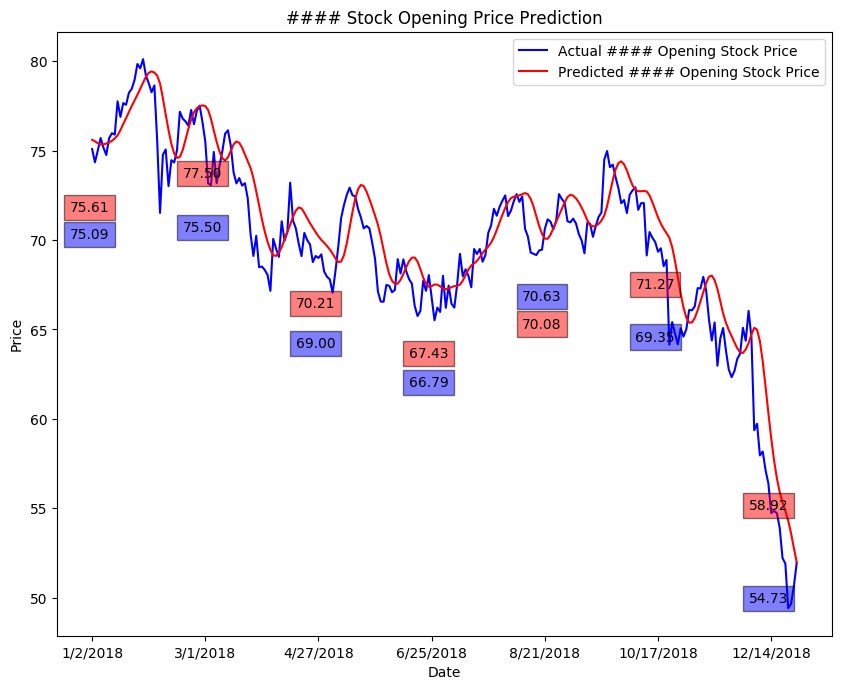

Train Score: 0.00095480776646635730 MSE (0.03089996385865778628 RMSE)
Test Score: 0.00242159217596054060 MSE (0.04920967563356357793 RMSE)


In [0]:
rsp = real_stock_price.iloc[:,0:1].values
plt.figure(1, figsize=(10, 8), dpi= 100)
plt.plot(rsp, color = 'blue', label = 'Actual #### Opening Stock Price')
plt.plot(predicted_stock_price[:,0:1], color = 'red', label = 'Predicted #### Opening Stock Price')
plt.title('#### Stock Opening Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(np.arange(0,250,40), (date[0],date[40],date[80],date[120],date[160],date[200], date[240]))
for j, i,count in zip(rsp, predicted_stock_price[:,0:1], range(250)):
    if (count%40 == 0):
      if (i.item()>j.item()):
        plt.text(count-8, i.item()-5+1, "%.2f"%(i), bbox=dict(facecolor='red', alpha=0.5)) 
        plt.text(count-8, j.item()-5, "%.2f"%(j), bbox=dict(facecolor='blue', alpha=0.5)) 
      elif (j.item()>i.item()):
        plt.text(count-8, i.item()-5, "%.2f"%(i), bbox=dict(facecolor='red', alpha=0.5)) 
        plt.text(count-8, j.item()-5+1, "%.2f"%(j), bbox=dict(facecolor='blue', alpha=0.5)) 
plt.show()
trainScore = lstm1.evaluate(X_train1, y_train1, verbose=0)
print('Train Score: %.20f MSE (%.20f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = lstm1.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.20f MSE (%.20f RMSE)' % (testScore, math.sqrt(testScore)))

In [0]:
# get actual values for mse 
# https://stackoverflow.com/questions/48973140/how-to-interpret-mse-in-keras-regressor
# RMSE is directly interpretable in terms of measurement units
predicted_stock_price = lstm1.predict(X_test)
predicted_stock_price = np.hstack((predicted_stock_price, np.zeros((predicted_stock_price.shape[0], 2), dtype=predicted_stock_price.dtype))) # depending on the number of features.
MSE = mean_squared_error(y_test_actual, sc.inverse_transform(predicted_stock_price)[:,0])
RMSE = np.sqrt(MSE)
print(MSE)
print(RMSE)

predicted_stock_price = lstm1.predict(X_train1)
predicted_stock_price = np.hstack((predicted_stock_price, np.zeros((predicted_stock_price.shape[0], 2), dtype=predicted_stock_price.dtype))) # depending on the number of features.
MSE = mean_squared_error(y_train_actual, sc.inverse_transform(predicted_stock_price)[:,0])
RMSE = np.sqrt(MSE)
print(MSE)
print(RMSE)

4.074665833683212
2.018580152900353
1.606598078121834
1.2675165001379012


In [0]:
# set learning rate
#def lr_schedule(epoch):
#    lrate = 0.001
#    if epoch > 75:
#        lrate = 0.0005
#    if epoch > 100:
#        lrate = 0.0003
#    return lrate

# simple early stopping
#es = EarlyStopping(monitor='val_loss',patience=20, verbose=0, restore_best_weights=True)

# save imrovement weight every epoch
#mc= ModelCheckpoint('/content/drive/My Drive/Colab Notebooks/AI HA3/best_model.h5',
#                    monitor='val_loss',
#                    mode='min',
#                    save_best_only=True,
#                    save_weights_only=True,
#                    verbose=1)